# Fashion-MNIST Classification with Multilayer Perceptron Network

Import the Modules that are going to be used through the classifier

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
print(torch.__version__)
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

1.12.1


Import the dataset that we are going to use for the classifier and normalized it

In [3]:
# Define a composition of transformations that are going to be applied to the dataseet
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,))]) # mean and standard deviation

# Download and load the training data
trainset = datasets.FashionMNIST('./Pytorch_Data/data/', download=True, train=True, transform=transform)
# Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# Define a data loader for the training data
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('./Pytorch_Data/data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

Let's take a look at the data we are going to work with

In [4]:
data_iter = iter(trainloader)
images, labels =  data_iter.next()
print(labels)

tensor([5, 6, 9, 5, 0, 2, 2, 2, 1, 3, 9, 4, 7, 8, 1, 0, 2, 5, 5, 5, 9, 0, 3, 3,
        8, 2, 9, 8, 5, 3, 4, 3, 6, 0, 1, 0, 8, 8, 4, 3, 2, 0, 4, 2, 0, 3, 5, 7,
        3, 8, 6, 1, 8, 1, 9, 9, 5, 5, 7, 8, 0, 8, 6, 7])


The sample image is:



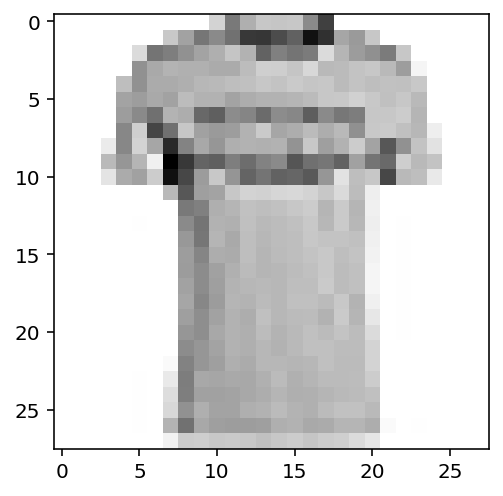

The label is:  tensor([0])


In [5]:
print("The sample image is:\n")
img = np.random.randint(len(images), size=1)
# print(X_train[img].squeeze().shape)
plt.imshow(images[img].squeeze(), cmap='binary')
plt.show()
print("The label is: ", labels[img])

In [6]:
def display_images_from_data(train_data, test_data, rows = 3, cols = 4, figsize_x = 15, figsize_y = 10):
    rand_data_vector = np.random.randint(0, len(train_data), rows * cols)
    subplot_counter = 1
    plt.figure(figsize=(figsize_x, figsize_y))
    plt.suptitle('Images from train data', fontsize=20)
    fMnist_Labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, subplot_counter)
            plt.imshow(train_data[rand_data_vector[row+col]].squeeze(), cmap='binary')
            plt.title('Label: ' + fMnist_Labels[test_data[rand_data_vector[row+col]]])
            plt.axis('off')
            subplot_counter += 1
    plt.show()

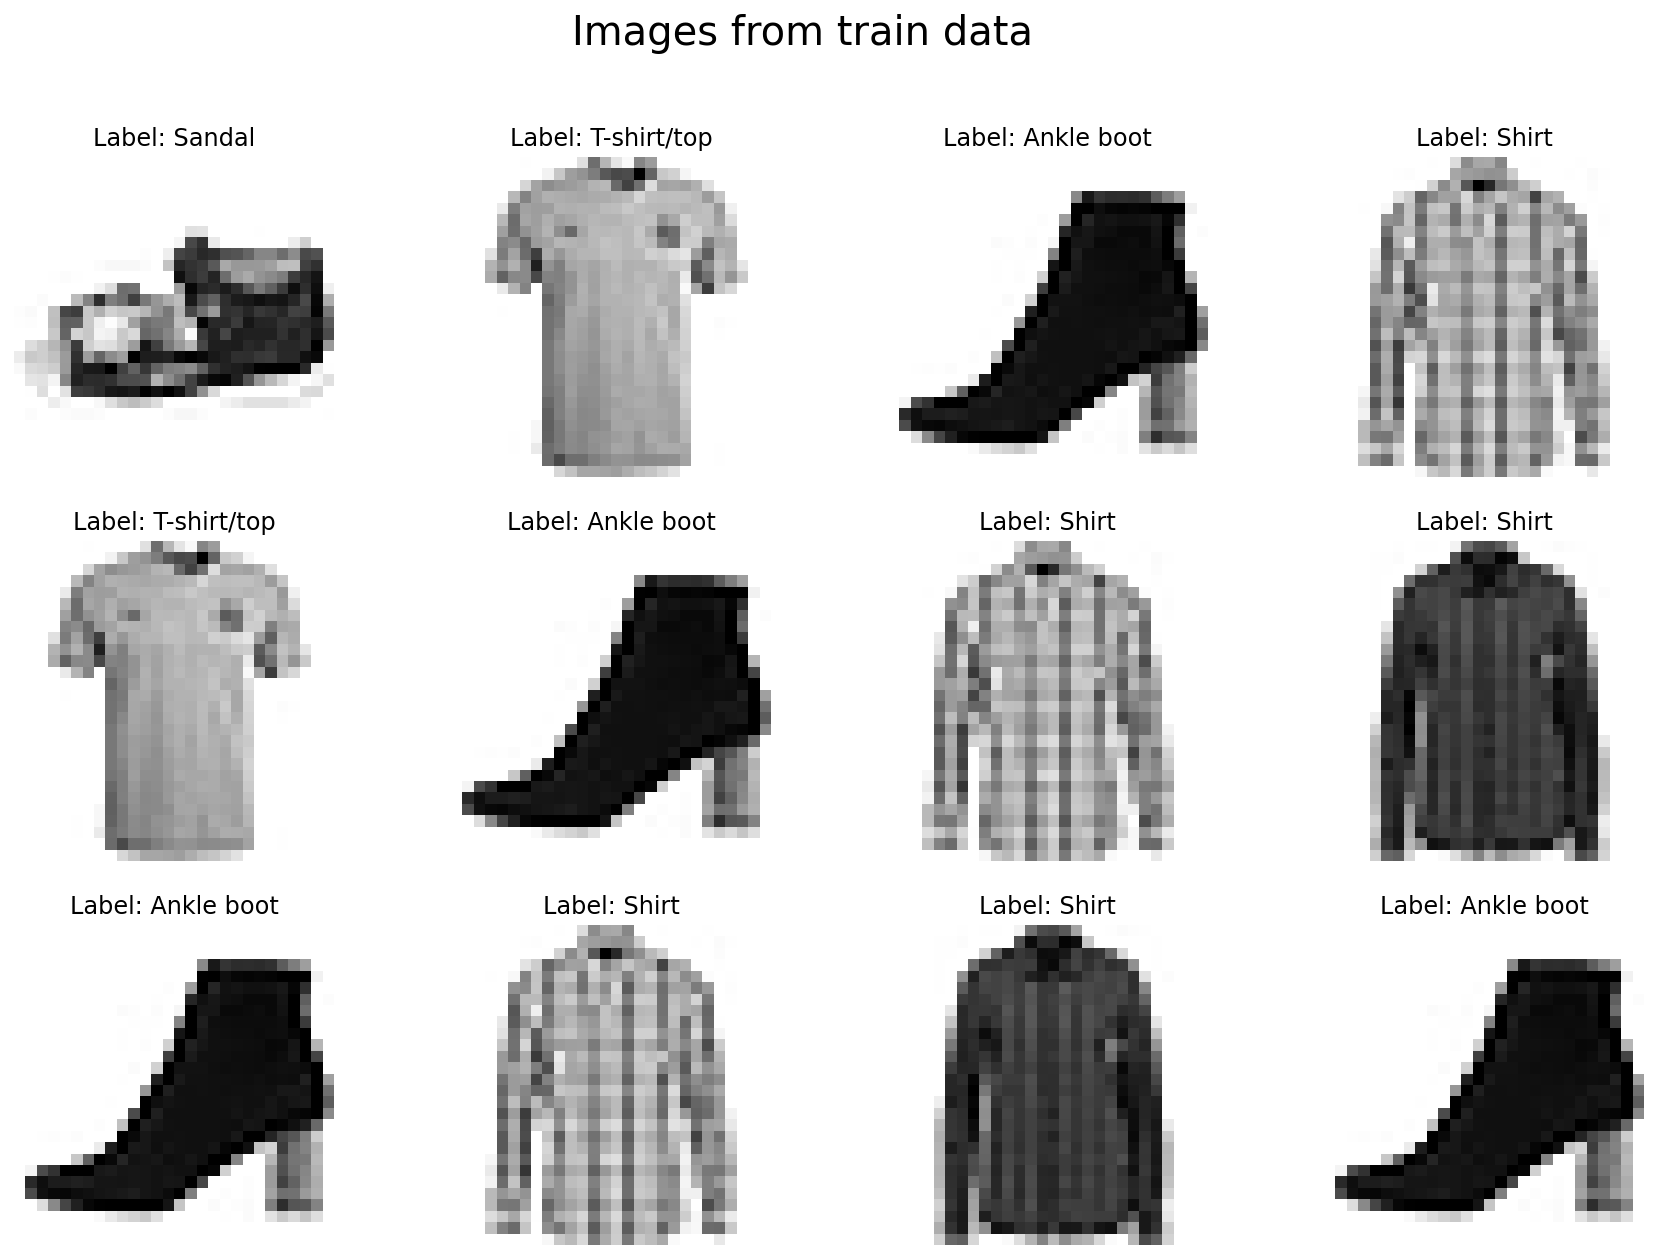

In [6]:
display_images_from_data(images, labels)

### Definition of the model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

### Instantiate the model and define the loss function and optimizer

In [8]:
model = Net()
model

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [9]:
# definition of the loss function
criterion = nn.NLLLoss()
# definition of the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def save_checkpoint(model, input_size = 784, hidden_layers = [128, 64], output_size = 10, filename='./save/checkpoint.pth'):
    print('Saving checkpoint...')
    checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)

### Definition of the training loop

In [11]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval() # Uses all the nodes in the model, so no dropout (dropout probability = 0)
            for images, labels in testloader:
                log_ps = model(images) # get the log-softmax output of the model
                test_loss += criterion(log_ps, labels) # calculate the cost
                
                ps = torch.exp(log_ps) # get the probability values
                top_prob, top_class = ps.topk(1, dim=1) # get the class with top probability
                equals = top_class == labels.view(*top_class.shape) # compare the predicted class with the label
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train() # takes into account the dropout
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        if (e+1) % 10 == 0:
            save_checkpoint(model, hidden_layers= [256, 128, 64], filename=f'./save/checkpoint_{e}.pth')

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.706..  Test Loss: 0.473..  Test Accuracy: 0.829
Epoch: 2/30..  Training Loss: 0.517..  Test Loss: 0.455..  Test Accuracy: 0.832
Epoch: 3/30..  Training Loss: 0.480..  Test Loss: 0.425..  Test Accuracy: 0.843
Epoch: 4/30..  Training Loss: 0.452..  Test Loss: 0.394..  Test Accuracy: 0.859
Epoch: 5/30..  Training Loss: 0.433..  Test Loss: 0.381..  Test Accuracy: 0.862
Epoch: 6/30..  Training Loss: 0.422..  Test Loss: 0.393..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.394..  Test Accuracy: 0.857
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.367..  Test Accuracy: 0.870
Epoch: 9/30..  Training Loss: 0.395..  Test Loss: 0.365..  Test Accuracy: 0.866
Saving checkpoint...
Epoch: 10/30..  Training Loss: 0.386..  Test Loss: 0.363..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.379..  Test Loss: 0.365..  Test Accuracy: 0.871
Epoch: 12/30..  Training Loss: 0.374..  Test Loss: 0.365..  Test Accuracy: 0.872
Epoch: 13/30..  

### Graph of the training and validation loss

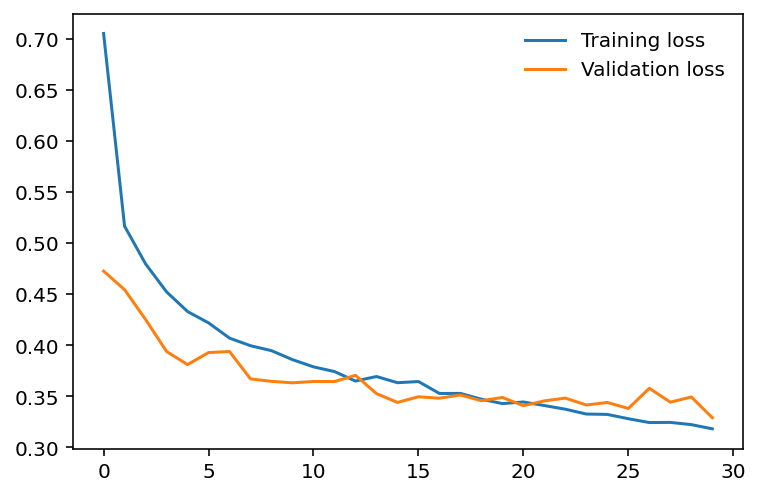

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Helper Function that shows the predicted class and its probability

In [13]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    _ , (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    fMnist_Labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    ax2.set_yticklabels(fMnist_Labels, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout() # Adjust the padding between and around subplots.

### Let's test our trained model

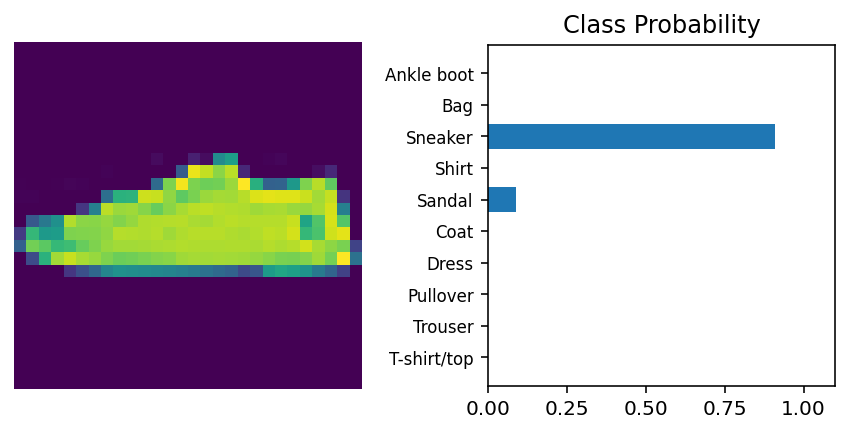

In [15]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
idx = np.random.randint(len(images), size=1)
img = images[idx]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps)